In [1]:
from src.ot_annotator2 import OTAnnotator
import time
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
from hyperopt import hp
import stlearn as st
import sys
import warnings
import os

warnings.filterwarnings("ignore")
np.random.seed(42) 

2025-01-07 16:04:03.020845: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-07 16:04:03.208236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-07 16:04:03.208275: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-07 16:04:04.343030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-

In [2]:
# output folder
out_folder = "tab_out3"
if not os.path.exists(out_folder):
    os.makedirs(out_folder, exist_ok=True)
else:
    print(f"Folder already exists: {out_folder}")


Folder already exists: tab_out3


In [3]:
# input data
dataset_paths = {
  '0027292__Region_1__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027292__Region_2__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027292__Region_3__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027292__Region_4__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027291__Region_1__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027291__Region_2__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027291__Region_3__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027291__Region_4__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027119__Region_1__20240621__120943': "/data/lemsaraa/amina/ST/ourData/20240621__120000__ST014_X0071_X0072_A4413/output-XETG00046__",
  '0027119__Region_2__20240621__120943': "/data/lemsaraa/amina/ST/ourData/20240621__120000__ST014_X0071_X0072_A4413/output-XETG00046__",
  '0027120__Region_1__20240621__120943':"/data/lemsaraa/amina/ST/ourData/20240621__120000__ST014_X0071_X0072_A4413/output-XETG00046__",
  '0027120__Region_2__20240621__120943': "/data/lemsaraa/amina/ST/ourData/20240621__120000__ST014_X0071_X0072_A4413/output-XETG00046__"
}

In [4]:
# hyperopt parameter space
# param_space = {
#             "reg": hp.loguniform("reg", np.log(0.0001), np.log(1)),
#             "reg_m_kl_1": hp.loguniform("reg_m_kl_1", np.log(0.0001), np.log(10)), #hp.uniform("reg_m_kl_1", 0, 500),
#             "reg_m_kl_2":hp.loguniform("reg_m_kl_2", np.log(0.0001), np.log(10)),# hp.uniform("reg_m_kl_2", 0, 500),
#             "method": hp.choice("method", ['sinkhorn']),
#             "reg_type": hp.choice("reg_type", ['entropy'])
#         }
param_space = {
            "reg": hp.loguniform("reg", np.log(0.0001), np.log(1)),
            "reg_m_kl_1": hp.choice("reg_m_kl_1",[float('inf'),hp.loguniform("reg_m_kl_1_", np.log(0.0001), np.log(10))]), #hp.uniform("reg_m_kl_1", 0, 500),
            "reg_m_kl_2": hp.choice("reg_m_kl_2",[float('inf'),hp.loguniform("reg_m_kl_2_", np.log(0.0001), np.log(10))]),# hp.uniform("reg_m_kl_2", 0, 500),
            "method": hp.choice("method", ['sinkhorn']),
            "reg_type": hp.choice("reg_type", ['kl'])
        }


# Load scRNAseq reference data with cell annotation

In [5]:
metadata=pd.read_csv('/data/lemsaraa/amina/ST/Xenium_analysis/tab/sc_metadata.csv',index_col=0)
metadata.head()

samples = {
    "BDP1083": "/data/lemsaraa/amina/ST/ourData/sc/06092024/cellranger/BDP1083_filtered_seurat_comp.h5",
    "BDP1105": "/data/lemsaraa/amina/ST/ourData/sc/06092024/cellranger/BDP1105_filtered_seurat_comp.h5",
    "BDP1130": "/data/lemsaraa/amina/ST/ourData/sc/06092024/cellranger/BDP1130_filtered_seurat_comp.h5",
    "BDP1131": "/data/lemsaraa/amina/ST/ourData/sc/06092024/cellranger/BDP1131_filtered_seurat_comp.h5",
}
adatas = {}
for sample_id, path in samples.items():
    sample_adata = sc.read_10x_h5(path)
    sample_adata.obs_names= sample_id+'_'+sample_adata.obs_names
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata_ref = ad.concat(adatas, label="sample")
adata_ref=adata_ref[metadata.index,:]
adata_ref.obs=metadata

In [10]:
# function to compute pearson correlation and cosine similarity for reconstructed genes
def calculate_similarity(annotator, gene_interest, leftout):
    from numpy.linalg import norm
    if way=='all':
        obs_names = annotator.adata.obs_names
        X_org = pd.DataFrame(
            annotator.adata[:, gene_interest].X.toarray(), columns=gene_interest)
        X_org.index = obs_names
    else:
        annotator.adata=annotator._compute_celltype_means(annotator.adata, key='membership', gene_interest=annotator.gene_interest)        
        obs_names = annotator.adata.obs_names
        X_org = pd.DataFrame(
            annotator.adata[:, gene_interest].X.toarray(), columns=gene_interest)
        X_org.index = obs_names
        
        
    annotator.X_reconstructed.index = obs_names
    X_pred = annotator.X_reconstructed.loc[:, gene_interest]

    # Initialize results list
    results = []
    leftout=[item for item in leftout if item in gene_interest]
    for gene in leftout:
        # Calculate correlation
        correlation = np.corrcoef(X_pred[gene].values, X_org[gene].values)[0, 1]

        # Calculate cosine similarity
        vec1 = X_pred[gene].values
        vec2 = X_org[gene].values
        cosine_similarity = np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

        # Append results as a dictionary
        results.append({
            'gene': gene,
            'correlation': correlation,
            'cosine': cosine_similarity
        })

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    return results_df


# LeftOut Genes Estimation (per cell)

In [7]:
# genes=pd.Series(pd.read_csv('data/added_genes.csv').values.flatten())
# genes = genes.sample(frac=1, random_state=42).reset_index(drop=True)
# sets = [genes[i:i + 32].tolist() for i in range(0, len(genes), 32)]
# random_sets = pd.DataFrame(sets).T
# random_sets.to_csv('data/random_added_genes.csv')

In [8]:
random_sets= pd.read_csv('data/random_added_genes.csv',index_col=0)


In [9]:
result_df=pd.DataFrame()
task='GEestimationRandom'
way = 'all'
verbose = True
nb_cluster = 10
metric = 'cosine'
op_iter = 100
key_ref = 'celltype_l2'
key_tar = 'leiden'
log_file = open(f"{out_folder}/{task}_verbose_matchit_{way}_{key_ref}.log", "w")
sys.stdout = log_file  # Redirect print to the log file

print(f"""
            ##Configuration:
            Task = {task}
            mapping_strategy = {way}
            distance_metric = {metric}
            reference_annotation = {key_ref}
            target_clustering = {key_tar}
            nb_clusters = {nb_cluster}        
            HyperOPT_iterations = {op_iter}
            """)

for leftout_col in range(3):
    leftout = random_sets.loc[:,str(leftout_col)].values
    print('leftout genes:')
    print(leftout)
# Iterate through datasets and their paths
    for DATASET, DATA_DIR in dataset_paths.items():
        # Path for the current dataset
        path = DATA_DIR + DATASET + "/"
        start_time = time.time() 
        print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")    
        # Read Xenium dataset
        adata = st.ReadXenium(
            feature_cell_matrix_file=path + "cell_feature_matrix.h5",
            cell_summary_file=path + "cells.csv.gz"
        )

        # Identify genes of interest
        gene_interest_ = adata_ref.var_names.intersection(adata.var_names)
        gene_interest = [gene for gene in gene_interest_ if gene not in leftout]
        # Initialize OTAnnotator

        annotator = OTAnnotator(
            adata, 
            adata_ref, 
            gene_interest, 
            param_space=param_space,
            key_ref=key_ref, 
            key_tar=key_tar, 
            way=way, 
            verbose=verbose
        )
        print('***Step1: Subcluster reference and target***') 
        annotator.subcluster(nb_cluster=nb_cluster)
        print('***Step2: Mapping***')
        annotator.annotate(op_iter=op_iter, metric=metric)
        print('***Step3: Evaluate Reconstruction***')
        # Calculate similarity and save to file
        res=calculate_similarity(
            annotator, 
            gene_interest_, 
            leftout 
        )
        res['dataset']=DATASET
        result_df= pd.concat([result_df,res], ignore_index=True)
        end_time = time.time()
        print(f"End time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
        print(f"Execution time: {end_time - start_time:.2f} seconds")
        print(annotator.best_params)
        # Restore standard output and close the log file
        
result_df.to_csv(f"{out_folder}/{task}_matchit_{way}_{key_ref}.csv")
print("\nEnded successfully.") 
sys.stdout = sys.__stdout__  # Reset to normal console output
log_file.close()


In [7]:
dot_res=pd.read_csv('tab_out2/GEestimationRandom_dot.csv')
result_df=pd.read_csv('tab_out2/GEestimationRandom_matchit_all_celltype_l2.csv')

dot_res=dot_res[['gene','gorrelation','cosine','dataset']]
dot_res

,gene,gorrelation,cosine,dataset
0,Inhbb,0.078175,0.111763,0027292__Region_1__20240530__125814
1,Nphs2,0.702057,0.721658,0027292__Region_1__20240530__125814
2,Optn,0.232767,0.320916,0027292__Region_1__20240530__125814
3,Vim,0.528268,0.606615,0027292__Region_1__20240530__125814
4,Lmx1b,0.551952,0.562879,0027292__Region_1__20240530__125814
...,...,...,...,...
1075,Enox1,0.284932,0.317477,0027120__Region_2__20240621__120943
1076,Rgcc,0.369427,0.471871,0027120__Region_2__20240621__120943
1077,Slc45a4,0.399631,0.573531,0027120__Region_2__20240621__120943
1078,Lgals1,0.195574,0.377878,0027120__Region_2__20240621__120943


In [12]:
# dot_res.columns=['gene','correlation','cosine','dataset']
result_df['method']='mapit'
dot_res['method']='dot'
all_df=pd.concat([dot_res,result_df],axis=0,ignore_index=True)
all_df

,gene,correlation,cosine,dataset,method,Unnamed: 0
0,Inhbb,0.078175,0.111763,0027292__Region_1__20240530__125814,dot,NaN
1,Nphs2,0.702057,0.721658,0027292__Region_1__20240530__125814,dot,NaN
2,Optn,0.232767,0.320916,0027292__Region_1__20240530__125814,dot,NaN
3,Vim,0.528268,0.606615,0027292__Region_1__20240530__125814,dot,NaN
4,Lmx1b,0.551952,0.562879,0027292__Region_1__20240530__125814,dot,NaN
...,...,...,...,...,...,...
2155,Serpine2,0.615379,0.653223,0027120__Region_2__20240621__120943,mapit,1075.0
2156,Dll4,0.272280,0.317510,0027120__Region_2__20240621__120943,mapit,1076.0
2157,Plac8,0.284535,0.408158,0027120__Region_2__20240621__120943,mapit,1077.0
2158,Pak1,0.463688,0.566459,0027120__Region_2__20240621__120943,mapit,1078.0


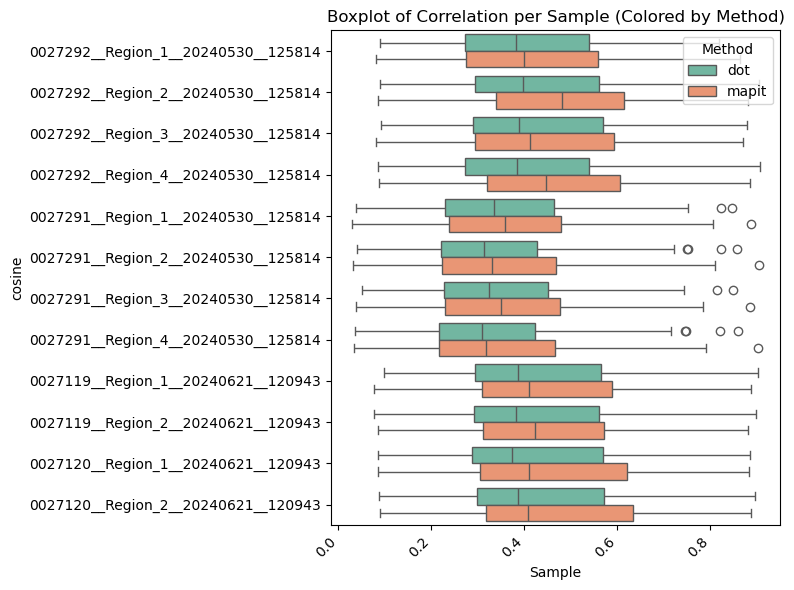

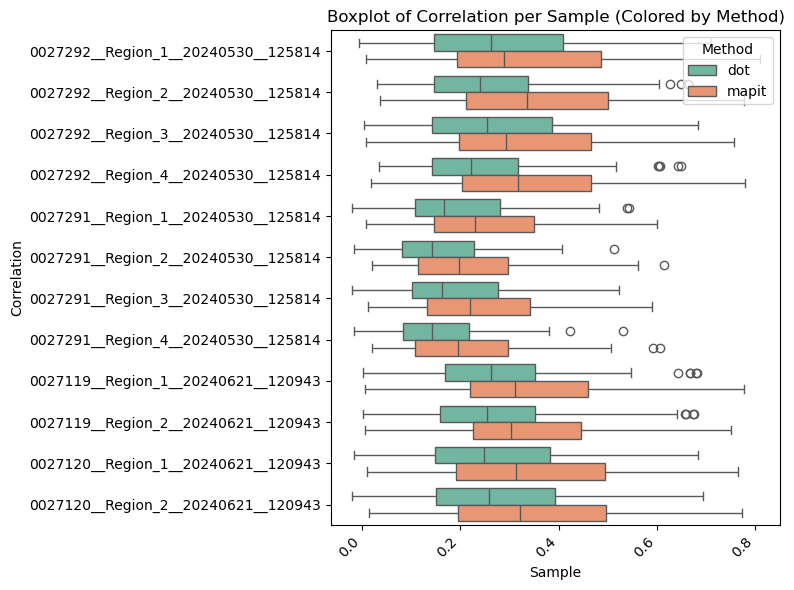

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

dot_res=pd.read_csv('tab_out2/GEestimationRandom_dot.csv')
result_df=pd.read_csv('tab_out2/GEestimationRandom_matchit_all_celltype_l2.csv')

dot_res=dot_res[['gene','gorrelation','cosine','dataset']]
dot_res
# dot_res.columns=['gene','correlation','cosine','dataset']
result_df['method']='mapit'
dot_res['method']='dot'
all_df=pd.concat([dot_res,result_df],axis=0,ignore_index=True)
all_df
# Plot the boxplot
df=all_df
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df, 
    y="dataset", 
    x="cosine", 
    hue="method", 
    palette="Set2"
)
plt.title("Boxplot of Correlation per Sample (Colored by Method)")
plt.xlabel("Sample")
plt.ylabel("cosine")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.legend(title="Method", loc="upper right")
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df, 
    y="dataset", 
    x="correlation", 
    hue="method", 
    palette="Set2"
)
plt.title("Boxplot of Correlation per Sample (Colored by Method)")
plt.xlabel("Sample")
plt.ylabel("Correlation")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.legend(title="Method", loc="upper right")
plt.show()

# LeftOut Genes Estimation (per subcluster of cells)

In [ ]:
result_df=pd.DataFrame()
task='GEestimationRandom'
way = 'mean'
verbose = True
nb_cluster = 10
metric = 'cosine'
op_iter = 100
key_ref = 'celltype_l2'
key_tar = 'leiden'
log_file = open(f"{out_folder}/{task}_verbose_matchit_{way}_{key_ref}.log", "w")
sys.stdout = log_file  # Redirect print to the log file

print(f"""
            ##Configuration:
            Task = {task}
            mapping_strategy = {way}
            distance_metric = {metric}
            reference_annotation = {key_ref}
            target_clustering = {key_tar}
            nb_clusters = {nb_cluster}        
            HyperOPT_iterations = {op_iter}
            """)

for leftout_col in range(3):
    leftout = random_sets.loc[:,str(leftout_col)].values
    print('leftout genes:')
    print(leftout)
# Iterate through datasets and their paths
    for DATASET, DATA_DIR in dataset_paths.items():
        # Path for the current dataset
        path = DATA_DIR + DATASET + "/"
        start_time = time.time() 
        print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}")    
        # Read Xenium dataset
        adata = st.ReadXenium(
            feature_cell_matrix_file=path + "cell_feature_matrix.h5",
            cell_summary_file=path + "cells.csv.gz"
        )

        # Identify genes of interest
        gene_interest_ = adata_ref.var_names.intersection(adata.var_names)
        gene_interest = [gene for gene in gene_interest_ if gene not in leftout]
        # Initialize OTAnnotator

        annotator = OTAnnotator(
            adata, 
            adata_ref, 
            gene_interest, 
            param_space=param_space,
            key_ref=key_ref, 
            key_tar=key_tar, 
            way=way, 
            verbose=verbose
        )
        print('***Step1: Subcluster reference and target***') 
        annotator.subcluster(nb_cluster=nb_cluster)
        print('***Step2: Mapping***')
        annotator.annotate(op_iter=op_iter, metric=metric)
        print('***Step3: Evaluate Reconstruction***')
        # Calculate similarity and save to file
        res=calculate_similarity(
            annotator, 
            gene_interest_, 
            leftout 
        )
        res['dataset']=DATASET
        result_df= pd.concat([result_df,res], ignore_index=True)
        end_time = time.time()
        print(f"End time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
        print(f"Execution time: {end_time - start_time:.2f} seconds")
        print(annotator.best_params)
        # Restore standard output and close the log file
        
result_df.to_csv(f"{out_folder}/{task}_matchit_{way}_{key_ref}.csv")
print("\nEnded successfully.") 
sys.stdout = sys.__stdout__  # Reset to normal console output
log_file.close()


In [ ]:
# comp_viz=compare_viz(annotator.adata[:,gene_interest],annotator.adata_ref[:,gene_interest],'cell_type_lvl4')

# markers=['Rac2','Slc5a1','Kng2','Clcnkb','Kcnj1','Nox4','Gatm','Thsd7a','Smarca2','Mmp9','Anxa2','Kdr','Rgcc','Tie1','Bst1','Itga8','Myl9','Fbln5','Bgn','Cfh','Plat']
# comp_viz.dotplot('predicted_annotation','Tcell',['dot'],markers)
# comp_viz.dotplot('dot','Tcell',['predicted_annotation'],markers)

In [ ]:
# plotT=plot_hp(annotator.trials,list(param_space.keys()))
# plotT.plot_trials()
# plotT.trials_loss_history('tt')